<a href="https://colab.research.google.com/github/dolmani38/AMD-GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow

In [1]:
# Imports
import os
import time
import shutil
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Dropout, Flatten

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

In [2]:
# Parameters
ALPHA = 0.2
GAUSS_SD = 0.02
MOMENTUM = 0.9
DROPOUT = 0.4

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.99
GEN_LEARNING_RATE = 0.0001
DIS_LEARNING_RATE = 0.0004

MAX_ITER = 30000
NUM_CLASSES = 10
SAVE_PERIOD = 250
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 128
FID_BATCH_SIZE = 1000

LATENT_DIM = 100
GENERATOR_INPUT = (100,)
DISCRIMINATOR_INPUT = (32, 32, 3)
INCEPTION_SHAPE = (299, 299, 3)

GRID_SIZE = 8
GRID_IMGS = 64  # GRID_SIZE * GRID_SIZE

In [3]:
# Create save directories
os.makedirs('DCGAN', exist_ok=True)
os.makedirs('./DCGAN/train_images', exist_ok=True)

In [4]:
def preprocess(image):
    """
    Converts the pixel values to the interval [-1. 1]
    :param image: Image matrix
    :return: Scaled images
    """
    return (image / 255) * 2 - 1


def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))


def generate_labels(n_samples):
    """
    Generates an array of ones(TRUE) and zeroes(FALSE) labels
    :param n_samples: The number of samples
    :return: Labels
    """
    return np.ones([n_samples, 1]), np.zeros([n_samples, 1])


def smooth_positive_labels(y):
    """
    Label smoothing postive labels to [0.9, 1.0]
    :param y: label
    :return: Smoothed labels
    """
    return y - 0.1 + (np.random.random(y.shape) * 0.1)


def smooth_negative_labels(y):
    """
    Label smoothing postive labels to [0, 0.1]
    :param y: label
    :return: Smoothed labels
    """
    return y + (np.random.random(y.shape) * 0.1)

In [5]:
def plot_image_grid(epoch, generated_images):
    """
    Plots the grid of images generated and end of each epoch
    :param epoch: the epoch number
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./DCGAN/train_images/image_iteration_{:05d}.png'.format(epoch + 1))
    plt.close()


def plot_final_grid(generated_images):
    """
    Plots the grid of images generated from final model
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./DCGAN/generated_image_grid.png')
    plt.savefig('./results/DCGAN.png')
    plt.show()

In [6]:
# The following FID calculation code has been adapted from Machine learning mastery
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# Inceptionv3 model for FID calculation
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)


def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)


def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """
    
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

87916544/87910968 [==============================] - 2s 0us/step


In [8]:
def discriminator_model():
    """
    Create and return a discriminator model
    :return: discriminator model
    """

    Discriminator = Sequential(name='Discriminator')

    # Downsampling : 32x32x3 --> 16x16x64
    Discriminator.add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding='same', 
                             kernel_initializer=RandomNormal(stddev=GAUSS_SD), 
                             input_shape=DISCRIMINATOR_INPUT))
    Discriminator.add(LeakyReLU(ALPHA))

    # Downsampling : 16x16x64 --> 8x8x128
    Discriminator.add(Conv2D(filters=128, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(BatchNormalization(momentum=MOMENTUM))
    Discriminator.add(LeakyReLU(ALPHA))

    # Downsampling : 8x8x128 --> 4x4x256
    Discriminator.add(Conv2D(filters=256, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(BatchNormalization(momentum=MOMENTUM))
    Discriminator.add(LeakyReLU(ALPHA))

    # Downsampling : 4x4x256 --> 2x2x512
    Discriminator.add(Conv2D(filters=512, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(BatchNormalization(momentum=MOMENTUM))
    Discriminator.add(LeakyReLU(ALPHA))

    # Fully Connected Layer (classifier) , 2x2x512 (2048) --> 1
    Discriminator.add(Flatten())
    Discriminator.add(Dropout(DROPOUT))
    Discriminator.add(Dense(1, activation='sigmoid'))

    return Discriminator


def generator_model():
    """
    Create and return a discriminator model
    :return: discriminator model
    """

    Generator = Sequential(name='Generator')

    # Fully Connected layer --> 512 activation maps of 2x2  
    Generator.add(Dense(units=512 * 2 * 2, input_shape=GENERATOR_INPUT, kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(Reshape((2, 2, 512)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 2x2x512 --> 4x4x256 
    Generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 4x4x256 --> 8x8x128 
    Generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 8x8x128 --> 16x16x64
    Generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 16x16x63 --> 32x32x3 
    Generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD), activation='tanh'))

    return Generator

def DCGAN_model():
    """
    Creates and returns the GAN, gnerator and discriminator models
    :return: GAN, gnerator and discriminator models
    """
    
    # Generator model
    Generator = generator_model()

    # Discriminator model
    Discriminator = discriminator_model()
    Discriminator.compile(optimizer=Adam(lr=DIS_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # GAN model
    GAN = Sequential([Generator, Discriminator])
    GAN.compile(optimizer=Adam(lr=GEN_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss='binary_crossentropy', metrics=['binary_accuracy'])

    return GAN, Generator, Discriminator


In [9]:
def train_DCGAN():
    """
    Function to train the GAN, gnerator and discriminator models
    """

    best_fid_score = 1000
    if os.path.exists('./DCGAN/best_fid_score.txt'):
        best_fid_score = float(next(open('best_fid.txt')))
        print('Best FID Score :', best_fid_score)

    # Calculate the previous iteration counts if the model was trained before
    prev_iters = 0
    if os.path.exists('./DCGAN/fid_scores.txt'):
        prev_iters = (sum(1 for line in open('fid_scores.txt'))) * SAVE_PERIOD
        print('Previous iteration count :', prev_iters)

    # Generate labels for training and evaluation batches
    Y_train_real, Y_train_fake = generate_labels(TRAIN_BATCH_SIZE)
    Y_eval_real, Y_eval_fake = generate_labels(EVAL_BATCH_SIZE)

    # Load existing model if exists or create a new model
    if os.path.exists('./model/DCGAN/best_GAN'):
        print("Saved model found. Loading model.")

        generator = load_model('./model/DCGAN/best_generator')
        print("Loaded Generator")

        discriminator = load_model('./model/DCGAN/best_discriminator')
        print("Loaded Discriminator")

        GAN = load_model('./model/DCGAN/best_GAN')
        print("Loaded GAN")

        discriminator.compile(optimizer=Adam(lr=DIS_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = 'binary_crossentropy', metrics=['accuracy'])
        GAN.compile(optimizer=Adam(lr=GEN_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = 'binary_crossentropy', metrics=['accuracy'])

    else:
        GAN, generator, discriminator = DCGAN_model()
        print("Created new GAN, Generator and Discriminator")

    for iters in range(MAX_ITER):
        print("Iteration : ", iters + prev_iters)

        # TRAIN - DISCRIMINATOR MODEL
        discriminator.trainable = True

        # Sample a train subset from real images
        X_batch_real = X_train[np.random.choice(X_train.shape[0], TRAIN_BATCH_SIZE, replace=True), :]

        # Generate fake samples
        latent_samples = generate_latent_samples(TRAIN_BATCH_SIZE, LATENT_DIM)
        X_batch_fake = generator.predict_on_batch(latent_samples)

        # Train the discriminator to detect real and fake images 
        discriminator.train_on_batch(X_batch_real, smooth_positive_labels(Y_train_real))
        discriminator.train_on_batch(X_batch_fake, smooth_negative_labels(Y_train_fake))

        # TRAIN - GENERATOR MODEL
        discriminator.trainable = False
        GAN.train_on_batch(latent_samples, Y_train_real)

        # Calculate and record loss, FID for every SAVE_PERIOD iterations
        if (iters + 1) % SAVE_PERIOD == 0:
            # Generate latent samples
            latent_samples = generate_latent_samples(EVAL_BATCH_SIZE, 100)
            GAN_images = generator.predict_on_batch(latent_samples)

            # Sample a subset of test images
            X_eval_real = X_test[np.random.choice(len(X_test), EVAL_BATCH_SIZE, replace=True), :]

            # Calculating losses
            discriminator_loss_real = discriminator.test_on_batch(X_eval_real, Y_eval_real)
            discriminator_loss_fake = discriminator.test_on_batch(GAN_images, Y_eval_fake)
            discriminator_loss_batch = 0.5 * (round(discriminator_loss_real[0], 10) + round(discriminator_loss_fake[0], 10))

            generator_loss_batch = GAN.test_on_batch(latent_samples, Y_eval_real)

            with open('./DCGAN/losses.txt', "a") as file:
                file.write("DIS_LOSS_BATCH: {}, GEN_LOSS_BATCH: {}".format(generator_loss_batch, round(generator_loss_batch[0], 10))) 
                file.write('\n')

            # Calculation FID 
            latent_samples = generate_latent_samples(FID_BATCH_SIZE, LATENT_DIM)
            GAN_images = generator.predict_on_batch(latent_samples)
            GAN_images = scale_images(GAN_images.astype('float32'), INCEPTION_SHAPE)

            X_test_batch = X_test[np.random.choice(len(X_test), FID_BATCH_SIZE, replace=True), :]
            X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

            cur_fid_score = calculate_fid(inception, X_test_batch, GAN_images)

            with open('./DCGAN/fid_scores.txt', "a") as file:
                file.write("{} {}".format(iters + 1 + prev_iters, round(cur_fid_score, 5)))
                file.write('\n')

            # Plot and save a grid of generated images
            plot_image_grid(iters + prev_iters, GAN_images)

            # If current model better than previous saved (best) model, save the new one
            if cur_fid_score < best_fid_score:
                best_fid_score = cur_fid_score

                with open('./DCGAN/best_fid.txt', "w") as file:
                    file.write(str(cur_fid_score))

                # Save the Generator model
                if os.path.exists('./model/DCGAN/best_generator'):
                    shutil.rmtree('./model/DCGAN/best_generator')

                generator.save('./model/DCGAN/best_generator')

                # Save the Discriminator model
                if os.path.exists('./model/DCGAN/best_discriminator'):
                    shutil.rmtree('./model/DCGAN/best_discriminator')

                discriminator.save('./model/DCGAN/best_discriminator')

                # Save the GAN model
                if os.path.exists('./model/DCGAN/best_GAN'):
                    shutil.rmtree('./model/DCGAN/best_GAN')

                GAN.save('./model/DCGAN/best_GAN')
    return

In [ ]:
# Loading Data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Training the model
train_DCGAN()

170500096/170498071 [==============================] - 11s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Created new GAN, Generator and Discriminator
Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19
Iteration :  20
Iteration :  21
Iteration :  22
Iteration :  23
Iteration :  24
Iteration :  25
Iteration :  26
Iteration :  27
Iteration :  28
Iteration :  29
Iteration :  30
Iteration :  31
Iteration :  32
Iteration :  33
Iteration :  34
Iteration :  35
Iteration :  36
Iteration :  37
Iteration :  38
Iteration :  39
Iteration :  40
Iteration :  41
Iteration :  42
Iteration :  43
Iteration :  44
Iteration :  45
Iteration :  46
Iteration :  47
Iteration :  48
Iteration :  49
Iteration :  50
Iteration :  51
Iteration :  52
Iteration :  53
Iteration :  54
Iteration :  55
Iteration :  56
Iteration :  57
Iteration :  58
Iteration :  59
Itera

INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  250
Iteration :  251
Iteration :  252
Iteration :  253
Iteration :  254
Iteration :  255
Iteration :  256
Iteration :  257
Iteration :  258
Iteration :  259
Iteration :  260
Iteration :  261
Iteration :  262
Iteration :  263
Iteration :  264
Iteration :  265
Iteration :  266
Iteration :  267
Iteration :  268
Iteration :  269
Iteration :  270
Iteration :  271
Iteration :  272
Iteration :  273
Iteration :  274
Iteration :  275
Iteration :  276
Iteration :  277
Iteration :  278
Iteration :  279
Iteration :  280
Iteration :  281
Iteration :  282
Iteration :  283
Iteration :  284
Iteration :  285
Iteration :  286
Iteration :  287
Iteration :  288
Iteration :  289
Iteration :  290
Iteration :  291
Iteration :  292
Iteration :  293
Iteration :  294
Iteration :  295
Iteration :  296
Iteration :  297
Iteration :  298
Iteration :  299
Iteration :  300
Iteration :  301
Iteration :  302
Iteration :  303
Iteration :  304
Iteration :  305
Iteration :  306
Iteration :  307
Iteration :  3

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  500
Iteration :  501
Iteration :  502
Iteration :  503
Iteration :  504
Iteration :  505
Iteration :  506
Iteration :  507
Iteration :  508
Iteration :  509
Iteration :  510
Iteration :  511
Iteration :  512
Iteration :  513
Iteration :  514
Iteration :  515
Iteration :  516
Iteration :  517
Iteration :  518
Iteration :  519
Iteration :  520
Iteration :  521
Iteration :  522
Iteration :  523
Iteration :  524
Iteration :  525
Iteration :  526
Iteration :  527
Iteration :  528
Iteration :  529
Iteration :  530
Iteration :  531
Iteration :  532
Iteration :  533
Iteration :  534
Iteration :  535
Iteration :  536
Iteration :  537
Iteration :  538
Iteration :  539
Iteration :  540
Iteration :  541
Iteration :  542
Iteration :  543
Iteration :  544
Iteration :  545
Iteration :  546
Iteration :  547
Iteration :  548
Iteration :  549
Iteration :  550
Iteration :  551
Iteration :  552
Iteration :  553
Iteration :  554
Iteration :  555
Iteration :  556
Iteration :  557
Iteration :  5

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  750
Iteration :  751
Iteration :  752
Iteration :  753
Iteration :  754
Iteration :  755
Iteration :  756
Iteration :  757
Iteration :  758
Iteration :  759
Iteration :  760
Iteration :  761
Iteration :  762
Iteration :  763
Iteration :  764
Iteration :  765
Iteration :  766
Iteration :  767
Iteration :  768
Iteration :  769
Iteration :  770
Iteration :  771
Iteration :  772
Iteration :  773
Iteration :  774
Iteration :  775
Iteration :  776
Iteration :  777
Iteration :  778
Iteration :  779
Iteration :  780
Iteration :  781
Iteration :  782
Iteration :  783
Iteration :  784
Iteration :  785
Iteration :  786
Iteration :  787
Iteration :  788
Iteration :  789
Iteration :  790
Iteration :  791
Iteration :  792
Iteration :  793
Iteration :  794
Iteration :  795
Iteration :  796
Iteration :  797
Iteration :  798
Iteration :  799
Iteration :  800
Iteration :  801
Iteration :  802
Iteration :  803
Iteration :  804
Iteration :  805
Iteration :  806
Iteration :  807
Iteration :  8

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  1000
Iteration :  1001
Iteration :  1002
Iteration :  1003
Iteration :  1004
Iteration :  1005
Iteration :  1006
Iteration :  1007
Iteration :  1008
Iteration :  1009
Iteration :  1010
Iteration :  1011
Iteration :  1012
Iteration :  1013
Iteration :  1014
Iteration :  1015
Iteration :  1016
Iteration :  1017
Iteration :  1018
Iteration :  1019
Iteration :  1020
Iteration :  1021
Iteration :  1022
Iteration :  1023
Iteration :  1024
Iteration :  1025
Iteration :  1026
Iteration :  1027
Iteration :  1028
Iteration :  1029
Iteration :  1030
Iteration :  1031
Iteration :  1032
Iteration :  1033
Iteration :  1034
Iteration :  1035
Iteration :  1036
Iteration :  1037
Iteration :  1038
Iteration :  1039
Iteration :  1040
Iteration :  1041
Iteration :  1042
Iteration :  1043
Iteration :  1044
Iteration :  1045
Iteration :  1046
Iteration :  1047
Iteration :  1048
Iteration :  1049
Iteration :  1050
Iteration :  1051
Iteration :  1052
Iteration :  1053
Iteration :  1054
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  2000
Iteration :  2001
Iteration :  2002
Iteration :  2003
Iteration :  2004
Iteration :  2005
Iteration :  2006
Iteration :  2007
Iteration :  2008
Iteration :  2009
Iteration :  2010
Iteration :  2011
Iteration :  2012
Iteration :  2013
Iteration :  2014
Iteration :  2015
Iteration :  2016
Iteration :  2017
Iteration :  2018
Iteration :  2019
Iteration :  2020
Iteration :  2021
Iteration :  2022
Iteration :  2023
Iteration :  2024
Iteration :  2025
Iteration :  2026
Iteration :  2027
Iteration :  2028
Iteration :  2029
Iteration :  2030
Iteration :  2031
Iteration :  2032
Iteration :  2033
Iteration :  2034
Iteration :  2035
Iteration :  2036
Iteration :  2037
Iteration :  2038
Iteration :  2039
Iteration :  2040
Iteration :  2041
Iteration :  2042
Iteration :  2043
Iteration :  2044
Iteration :  2045
Iteration :  2046
Iteration :  2047
Iteration :  2048
Iteration :  2049
Iteration :  2050
Iteration :  2051
Iteration :  2052
Iteration :  2053
Iteration :  2054
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  2250
Iteration :  2251
Iteration :  2252
Iteration :  2253
Iteration :  2254
Iteration :  2255
Iteration :  2256
Iteration :  2257
Iteration :  2258
Iteration :  2259
Iteration :  2260
Iteration :  2261
Iteration :  2262
Iteration :  2263
Iteration :  2264
Iteration :  2265
Iteration :  2266
Iteration :  2267
Iteration :  2268
Iteration :  2269
Iteration :  2270
Iteration :  2271
Iteration :  2272
Iteration :  2273
Iteration :  2274
Iteration :  2275
Iteration :  2276
Iteration :  2277
Iteration :  2278
Iteration :  2279
Iteration :  2280
Iteration :  2281
Iteration :  2282
Iteration :  2283
Iteration :  2284
Iteration :  2285
Iteration :  2286
Iteration :  2287
Iteration :  2288
Iteration :  2289
Iteration :  2290
Iteration :  2291
Iteration :  2292
Iteration :  2293
Iteration :  2294
Iteration :  2295
Iteration :  2296
Iteration :  2297
Iteration :  2298
Iteration :  2299
Iteration :  2300
Iteration :  2301
Iteration :  2302
Iteration :  2303
Iteration :  2304
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  2500
Iteration :  2501
Iteration :  2502
Iteration :  2503
Iteration :  2504
Iteration :  2505
Iteration :  2506
Iteration :  2507
Iteration :  2508
Iteration :  2509
Iteration :  2510
Iteration :  2511
Iteration :  2512
Iteration :  2513
Iteration :  2514
Iteration :  2515
Iteration :  2516
Iteration :  2517
Iteration :  2518
Iteration :  2519
Iteration :  2520
Iteration :  2521
Iteration :  2522
Iteration :  2523
Iteration :  2524
Iteration :  2525
Iteration :  2526
Iteration :  2527
Iteration :  2528
Iteration :  2529
Iteration :  2530
Iteration :  2531
Iteration :  2532
Iteration :  2533
Iteration :  2534
Iteration :  2535
Iteration :  2536
Iteration :  2537
Iteration :  2538
Iteration :  2539
Iteration :  2540
Iteration :  2541
Iteration :  2542
Iteration :  2543
Iteration :  2544
Iteration :  2545
Iteration :  2546
Iteration :  2547
Iteration :  2548
Iteration :  2549
Iteration :  2550
Iteration :  2551
Iteration :  2552
Iteration :  2553
Iteration :  2554
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  3000
Iteration :  3001
Iteration :  3002
Iteration :  3003
Iteration :  3004
Iteration :  3005
Iteration :  3006
Iteration :  3007
Iteration :  3008
Iteration :  3009
Iteration :  3010
Iteration :  3011
Iteration :  3012
Iteration :  3013
Iteration :  3014
Iteration :  3015
Iteration :  3016
Iteration :  3017
Iteration :  3018
Iteration :  3019
Iteration :  3020
Iteration :  3021
Iteration :  3022
Iteration :  3023
Iteration :  3024
Iteration :  3025
Iteration :  3026
Iteration :  3027
Iteration :  3028
Iteration :  3029
Iteration :  3030
Iteration :  3031
Iteration :  3032
Iteration :  3033
Iteration :  3034
Iteration :  3035
Iteration :  3036
Iteration :  3037
Iteration :  3038
Iteration :  3039
Iteration :  3040
Iteration :  3041
Iteration :  3042
Iteration :  3043
Iteration :  3044
Iteration :  3045
Iteration :  3046
Iteration :  3047
Iteration :  3048
Iteration :  3049
Iteration :  3050
Iteration :  3051
Iteration :  3052
Iteration :  3053
Iteration :  3054
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  3500
Iteration :  3501
Iteration :  3502
Iteration :  3503
Iteration :  3504
Iteration :  3505
Iteration :  3506
Iteration :  3507
Iteration :  3508
Iteration :  3509
Iteration :  3510
Iteration :  3511
Iteration :  3512
Iteration :  3513
Iteration :  3514
Iteration :  3515
Iteration :  3516
Iteration :  3517
Iteration :  3518
Iteration :  3519
Iteration :  3520
Iteration :  3521
Iteration :  3522
Iteration :  3523
Iteration :  3524
Iteration :  3525
Iteration :  3526
Iteration :  3527
Iteration :  3528
Iteration :  3529
Iteration :  3530
Iteration :  3531
Iteration :  3532
Iteration :  3533
Iteration :  3534
Iteration :  3535
Iteration :  3536
Iteration :  3537
Iteration :  3538
Iteration :  3539
Iteration :  3540
Iteration :  3541
Iteration :  3542
Iteration :  3543
Iteration :  3544
Iteration :  3545
Iteration :  3546
Iteration :  3547
Iteration :  3548
Iteration :  3549
Iteration :  3550
Iteration :  3551
Iteration :  3552
Iteration :  3553
Iteration :  3554
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  4750
Iteration :  4751
Iteration :  4752
Iteration :  4753
Iteration :  4754
Iteration :  4755
Iteration :  4756
Iteration :  4757
Iteration :  4758
Iteration :  4759
Iteration :  4760
Iteration :  4761
Iteration :  4762
Iteration :  4763
Iteration :  4764
Iteration :  4765
Iteration :  4766
Iteration :  4767
Iteration :  4768
Iteration :  4769
Iteration :  4770
Iteration :  4771
Iteration :  4772
Iteration :  4773
Iteration :  4774
Iteration :  4775
Iteration :  4776
Iteration :  4777
Iteration :  4778
Iteration :  4779
Iteration :  4780
Iteration :  4781
Iteration :  4782
Iteration :  4783
Iteration :  4784
Iteration :  4785
Iteration :  4786
Iteration :  4787
Iteration :  4788
Iteration :  4789
Iteration :  4790
Iteration :  4791
Iteration :  4792
Iteration :  4793
Iteration :  4794
Iteration :  4795
Iteration :  4796
Iteration :  4797
Iteration :  4798
Iteration :  4799
Iteration :  4800
Iteration :  4801
Iteration :  4802
Iteration :  4803
Iteration :  4804
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  5750
Iteration :  5751
Iteration :  5752
Iteration :  5753
Iteration :  5754
Iteration :  5755
Iteration :  5756
Iteration :  5757
Iteration :  5758
Iteration :  5759
Iteration :  5760
Iteration :  5761
Iteration :  5762
Iteration :  5763
Iteration :  5764
Iteration :  5765
Iteration :  5766
Iteration :  5767
Iteration :  5768
Iteration :  5769
Iteration :  5770
Iteration :  5771
Iteration :  5772
Iteration :  5773
Iteration :  5774
Iteration :  5775
Iteration :  5776
Iteration :  5777
Iteration :  5778
Iteration :  5779
Iteration :  5780
Iteration :  5781
Iteration :  5782
Iteration :  5783
Iteration :  5784
Iteration :  5785
Iteration :  5786
Iteration :  5787
Iteration :  5788
Iteration :  5789
Iteration :  5790
Iteration :  5791
Iteration :  5792
Iteration :  5793
Iteration :  5794
Iteration :  5795
Iteration :  5796
Iteration :  5797
Iteration :  5798
Iteration :  5799
Iteration :  5800
Iteration :  5801
Iteration :  5802
Iteration :  5803
Iteration :  5804
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  6000
Iteration :  6001
Iteration :  6002
Iteration :  6003
Iteration :  6004
Iteration :  6005
Iteration :  6006
Iteration :  6007
Iteration :  6008
Iteration :  6009
Iteration :  6010
Iteration :  6011
Iteration :  6012
Iteration :  6013
Iteration :  6014
Iteration :  6015
Iteration :  6016
Iteration :  6017
Iteration :  6018
Iteration :  6019
Iteration :  6020
Iteration :  6021
Iteration :  6022
Iteration :  6023
Iteration :  6024
Iteration :  6025
Iteration :  6026
Iteration :  6027
Iteration :  6028
Iteration :  6029
Iteration :  6030
Iteration :  6031
Iteration :  6032
Iteration :  6033
Iteration :  6034
Iteration :  6035
Iteration :  6036
Iteration :  6037
Iteration :  6038
Iteration :  6039
Iteration :  6040
Iteration :  6041
Iteration :  6042
Iteration :  6043
Iteration :  6044
Iteration :  6045
Iteration :  6046
Iteration :  6047
Iteration :  6048
Iteration :  6049
Iteration :  6050
Iteration :  6051
Iteration :  6052
Iteration :  6053
Iteration :  6054
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  7000
Iteration :  7001
Iteration :  7002
Iteration :  7003
Iteration :  7004
Iteration :  7005
Iteration :  7006
Iteration :  7007
Iteration :  7008
Iteration :  7009
Iteration :  7010
Iteration :  7011
Iteration :  7012
Iteration :  7013
Iteration :  7014
Iteration :  7015
Iteration :  7016
Iteration :  7017
Iteration :  7018
Iteration :  7019
Iteration :  7020
Iteration :  7021
Iteration :  7022
Iteration :  7023
Iteration :  7024
Iteration :  7025
Iteration :  7026
Iteration :  7027
Iteration :  7028
Iteration :  7029
Iteration :  7030
Iteration :  7031
Iteration :  7032
Iteration :  7033
Iteration :  7034
Iteration :  7035
Iteration :  7036
Iteration :  7037
Iteration :  7038
Iteration :  7039
Iteration :  7040
Iteration :  7041
Iteration :  7042
Iteration :  7043
Iteration :  7044
Iteration :  7045
Iteration :  7046
Iteration :  7047
Iteration :  7048
Iteration :  7049
Iteration :  7050
Iteration :  7051
Iteration :  7052
Iteration :  7053
Iteration :  7054
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  7250
Iteration :  7251
Iteration :  7252
Iteration :  7253
Iteration :  7254
Iteration :  7255
Iteration :  7256
Iteration :  7257
Iteration :  7258
Iteration :  7259
Iteration :  7260
Iteration :  7261
Iteration :  7262
Iteration :  7263
Iteration :  7264
Iteration :  7265
Iteration :  7266
Iteration :  7267
Iteration :  7268
Iteration :  7269
Iteration :  7270
Iteration :  7271
Iteration :  7272
Iteration :  7273
Iteration :  7274
Iteration :  7275
Iteration :  7276
Iteration :  7277
Iteration :  7278
Iteration :  7279
Iteration :  7280
Iteration :  7281
Iteration :  7282
Iteration :  7283
Iteration :  7284
Iteration :  7285
Iteration :  7286
Iteration :  7287
Iteration :  7288
Iteration :  7289
Iteration :  7290
Iteration :  7291
Iteration :  7292
Iteration :  7293
Iteration :  7294
Iteration :  7295
Iteration :  7296
Iteration :  7297
Iteration :  7298
Iteration :  7299
Iteration :  7300
Iteration :  7301
Iteration :  7302
Iteration :  7303
Iteration :  7304
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  7750
Iteration :  7751
Iteration :  7752
Iteration :  7753
Iteration :  7754
Iteration :  7755
Iteration :  7756
Iteration :  7757
Iteration :  7758
Iteration :  7759
Iteration :  7760
Iteration :  7761
Iteration :  7762
Iteration :  7763
Iteration :  7764
Iteration :  7765
Iteration :  7766
Iteration :  7767
Iteration :  7768
Iteration :  7769
Iteration :  7770
Iteration :  7771
Iteration :  7772
Iteration :  7773
Iteration :  7774
Iteration :  7775
Iteration :  7776
Iteration :  7777
Iteration :  7778
Iteration :  7779
Iteration :  7780
Iteration :  7781
Iteration :  7782
Iteration :  7783
Iteration :  7784
Iteration :  7785
Iteration :  7786
Iteration :  7787
Iteration :  7788
Iteration :  7789
Iteration :  7790
Iteration :  7791
Iteration :  7792
Iteration :  7793
Iteration :  7794
Iteration :  7795
Iteration :  7796
Iteration :  7797
Iteration :  7798
Iteration :  7799
Iteration :  7800
Iteration :  7801
Iteration :  7802
Iteration :  7803
Iteration :  7804
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  8000
Iteration :  8001
Iteration :  8002
Iteration :  8003
Iteration :  8004
Iteration :  8005
Iteration :  8006
Iteration :  8007
Iteration :  8008
Iteration :  8009
Iteration :  8010
Iteration :  8011
Iteration :  8012
Iteration :  8013
Iteration :  8014
Iteration :  8015
Iteration :  8016
Iteration :  8017
Iteration :  8018
Iteration :  8019
Iteration :  8020
Iteration :  8021
Iteration :  8022
Iteration :  8023
Iteration :  8024
Iteration :  8025
Iteration :  8026
Iteration :  8027
Iteration :  8028
Iteration :  8029
Iteration :  8030
Iteration :  8031
Iteration :  8032
Iteration :  8033
Iteration :  8034
Iteration :  8035
Iteration :  8036
Iteration :  8037
Iteration :  8038
Iteration :  8039
Iteration :  8040
Iteration :  8041
Iteration :  8042
Iteration :  8043
Iteration :  8044
Iteration :  8045
Iteration :  8046
Iteration :  8047
Iteration :  8048
Iteration :  8049
Iteration :  8050
Iteration :  8051
Iteration :  8052
Iteration :  8053
Iteration :  8054
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  8250
Iteration :  8251
Iteration :  8252
Iteration :  8253
Iteration :  8254
Iteration :  8255
Iteration :  8256
Iteration :  8257
Iteration :  8258
Iteration :  8259
Iteration :  8260
Iteration :  8261
Iteration :  8262
Iteration :  8263
Iteration :  8264
Iteration :  8265
Iteration :  8266
Iteration :  8267
Iteration :  8268
Iteration :  8269
Iteration :  8270
Iteration :  8271
Iteration :  8272
Iteration :  8273
Iteration :  8274
Iteration :  8275
Iteration :  8276
Iteration :  8277
Iteration :  8278
Iteration :  8279
Iteration :  8280
Iteration :  8281
Iteration :  8282
Iteration :  8283
Iteration :  8284
Iteration :  8285
Iteration :  8286
Iteration :  8287
Iteration :  8288
Iteration :  8289
Iteration :  8290
Iteration :  8291
Iteration :  8292
Iteration :  8293
Iteration :  8294
Iteration :  8295
Iteration :  8296
Iteration :  8297
Iteration :  8298
Iteration :  8299
Iteration :  8300
Iteration :  8301
Iteration :  8302
Iteration :  8303
Iteration :  8304
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  8750
Iteration :  8751
Iteration :  8752
Iteration :  8753
Iteration :  8754
Iteration :  8755
Iteration :  8756
Iteration :  8757
Iteration :  8758
Iteration :  8759
Iteration :  8760
Iteration :  8761
Iteration :  8762
Iteration :  8763
Iteration :  8764
Iteration :  8765
Iteration :  8766
Iteration :  8767
Iteration :  8768
Iteration :  8769
Iteration :  8770
Iteration :  8771
Iteration :  8772
Iteration :  8773
Iteration :  8774
Iteration :  8775
Iteration :  8776
Iteration :  8777
Iteration :  8778
Iteration :  8779
Iteration :  8780
Iteration :  8781
Iteration :  8782
Iteration :  8783
Iteration :  8784
Iteration :  8785
Iteration :  8786
Iteration :  8787
Iteration :  8788
Iteration :  8789
Iteration :  8790
Iteration :  8791
Iteration :  8792
Iteration :  8793
Iteration :  8794
Iteration :  8795
Iteration :  8796
Iteration :  8797
Iteration :  8798
Iteration :  8799
Iteration :  8800
Iteration :  8801
Iteration :  8802
Iteration :  8803
Iteration :  8804
Iteration 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  11250
Iteration :  11251
Iteration :  11252
Iteration :  11253
Iteration :  11254
Iteration :  11255
Iteration :  11256
Iteration :  11257
Iteration :  11258
Iteration :  11259
Iteration :  11260
Iteration :  11261
Iteration :  11262
Iteration :  11263
Iteration :  11264
Iteration :  11265
Iteration :  11266
Iteration :  11267
Iteration :  11268
Iteration :  11269
Iteration :  11270
Iteration :  11271
Iteration :  11272
Iteration :  11273
Iteration :  11274
Iteration :  11275
Iteration :  11276
Iteration :  11277
Iteration :  11278
Iteration :  11279
Iteration :  11280
Iteration :  11281
Iteration :  11282
Iteration :  11283
Iteration :  11284
Iteration :  11285
Iteration :  11286
Iteration :  11287
Iteration :  11288
Iteration :  11289
Iteration :  11290
Iteration :  11291
Iteration :  11292
Iteration :  11293
Iteration :  11294
Iteration :  11295
Iteration :  11296
Iteration :  11297
Iteration :  11298
Iteration :  11299
Iteration :  11300
Iteration :  11301
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  12250
Iteration :  12251
Iteration :  12252
Iteration :  12253
Iteration :  12254
Iteration :  12255
Iteration :  12256
Iteration :  12257
Iteration :  12258
Iteration :  12259
Iteration :  12260
Iteration :  12261
Iteration :  12262
Iteration :  12263
Iteration :  12264
Iteration :  12265
Iteration :  12266
Iteration :  12267
Iteration :  12268
Iteration :  12269
Iteration :  12270
Iteration :  12271
Iteration :  12272
Iteration :  12273
Iteration :  12274
Iteration :  12275
Iteration :  12276
Iteration :  12277
Iteration :  12278
Iteration :  12279
Iteration :  12280
Iteration :  12281
Iteration :  12282
Iteration :  12283
Iteration :  12284
Iteration :  12285
Iteration :  12286
Iteration :  12287
Iteration :  12288
Iteration :  12289
Iteration :  12290
Iteration :  12291
Iteration :  12292
Iteration :  12293
Iteration :  12294
Iteration :  12295
Iteration :  12296
Iteration :  12297
Iteration :  12298
Iteration :  12299
Iteration :  12300
Iteration :  12301
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  12750
Iteration :  12751
Iteration :  12752
Iteration :  12753
Iteration :  12754
Iteration :  12755
Iteration :  12756
Iteration :  12757
Iteration :  12758
Iteration :  12759
Iteration :  12760
Iteration :  12761
Iteration :  12762
Iteration :  12763
Iteration :  12764
Iteration :  12765
Iteration :  12766
Iteration :  12767
Iteration :  12768
Iteration :  12769
Iteration :  12770
Iteration :  12771
Iteration :  12772
Iteration :  12773
Iteration :  12774
Iteration :  12775
Iteration :  12776
Iteration :  12777
Iteration :  12778
Iteration :  12779
Iteration :  12780
Iteration :  12781
Iteration :  12782
Iteration :  12783
Iteration :  12784
Iteration :  12785
Iteration :  12786
Iteration :  12787
Iteration :  12788
Iteration :  12789
Iteration :  12790
Iteration :  12791
Iteration :  12792
Iteration :  12793
Iteration :  12794
Iteration :  12795
Iteration :  12796
Iteration :  12797
Iteration :  12798
Iteration :  12799
Iteration :  12800
Iteration :  12801
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  14250
Iteration :  14251
Iteration :  14252
Iteration :  14253
Iteration :  14254
Iteration :  14255
Iteration :  14256
Iteration :  14257
Iteration :  14258
Iteration :  14259
Iteration :  14260
Iteration :  14261
Iteration :  14262
Iteration :  14263
Iteration :  14264
Iteration :  14265
Iteration :  14266
Iteration :  14267
Iteration :  14268
Iteration :  14269
Iteration :  14270
Iteration :  14271
Iteration :  14272
Iteration :  14273
Iteration :  14274
Iteration :  14275
Iteration :  14276
Iteration :  14277
Iteration :  14278
Iteration :  14279
Iteration :  14280
Iteration :  14281
Iteration :  14282
Iteration :  14283
Iteration :  14284
Iteration :  14285
Iteration :  14286
Iteration :  14287
Iteration :  14288
Iteration :  14289
Iteration :  14290
Iteration :  14291
Iteration :  14292
Iteration :  14293
Iteration :  14294
Iteration :  14295
Iteration :  14296
Iteration :  14297
Iteration :  14298
Iteration :  14299
Iteration :  14300
Iteration :  14301
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  15750
Iteration :  15751
Iteration :  15752
Iteration :  15753
Iteration :  15754
Iteration :  15755
Iteration :  15756
Iteration :  15757
Iteration :  15758
Iteration :  15759
Iteration :  15760
Iteration :  15761
Iteration :  15762
Iteration :  15763
Iteration :  15764
Iteration :  15765
Iteration :  15766
Iteration :  15767
Iteration :  15768
Iteration :  15769
Iteration :  15770
Iteration :  15771
Iteration :  15772
Iteration :  15773
Iteration :  15774
Iteration :  15775
Iteration :  15776
Iteration :  15777
Iteration :  15778
Iteration :  15779
Iteration :  15780
Iteration :  15781
Iteration :  15782
Iteration :  15783
Iteration :  15784
Iteration :  15785
Iteration :  15786
Iteration :  15787
Iteration :  15788
Iteration :  15789
Iteration :  15790
Iteration :  15791
Iteration :  15792
Iteration :  15793
Iteration :  15794
Iteration :  15795
Iteration :  15796
Iteration :  15797
Iteration :  15798
Iteration :  15799
Iteration :  15800
Iteration :  15801
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  17500
Iteration :  17501
Iteration :  17502
Iteration :  17503
Iteration :  17504
Iteration :  17505
Iteration :  17506
Iteration :  17507
Iteration :  17508
Iteration :  17509
Iteration :  17510
Iteration :  17511
Iteration :  17512
Iteration :  17513
Iteration :  17514
Iteration :  17515
Iteration :  17516
Iteration :  17517
Iteration :  17518
Iteration :  17519
Iteration :  17520
Iteration :  17521
Iteration :  17522
Iteration :  17523
Iteration :  17524
Iteration :  17525
Iteration :  17526
Iteration :  17527
Iteration :  17528
Iteration :  17529
Iteration :  17530
Iteration :  17531
Iteration :  17532
Iteration :  17533
Iteration :  17534
Iteration :  17535
Iteration :  17536
Iteration :  17537
Iteration :  17538
Iteration :  17539
Iteration :  17540
Iteration :  17541
Iteration :  17542
Iteration :  17543
Iteration :  17544
Iteration :  17545
Iteration :  17546
Iteration :  17547
Iteration :  17548
Iteration :  17549
Iteration :  17550
Iteration :  17551
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  18000
Iteration :  18001
Iteration :  18002
Iteration :  18003
Iteration :  18004
Iteration :  18005
Iteration :  18006
Iteration :  18007
Iteration :  18008
Iteration :  18009
Iteration :  18010
Iteration :  18011
Iteration :  18012
Iteration :  18013
Iteration :  18014
Iteration :  18015
Iteration :  18016
Iteration :  18017
Iteration :  18018
Iteration :  18019
Iteration :  18020
Iteration :  18021
Iteration :  18022
Iteration :  18023
Iteration :  18024
Iteration :  18025
Iteration :  18026
Iteration :  18027
Iteration :  18028
Iteration :  18029
Iteration :  18030
Iteration :  18031
Iteration :  18032
Iteration :  18033
Iteration :  18034
Iteration :  18035
Iteration :  18036
Iteration :  18037
Iteration :  18038
Iteration :  18039
Iteration :  18040
Iteration :  18041
Iteration :  18042
Iteration :  18043
Iteration :  18044
Iteration :  18045
Iteration :  18046
Iteration :  18047
Iteration :  18048
Iteration :  18049
Iteration :  18050
Iteration :  18051
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  19500
Iteration :  19501
Iteration :  19502
Iteration :  19503
Iteration :  19504
Iteration :  19505
Iteration :  19506
Iteration :  19507
Iteration :  19508
Iteration :  19509
Iteration :  19510
Iteration :  19511
Iteration :  19512
Iteration :  19513
Iteration :  19514
Iteration :  19515
Iteration :  19516
Iteration :  19517
Iteration :  19518
Iteration :  19519
Iteration :  19520
Iteration :  19521
Iteration :  19522
Iteration :  19523
Iteration :  19524
Iteration :  19525
Iteration :  19526
Iteration :  19527
Iteration :  19528
Iteration :  19529
Iteration :  19530
Iteration :  19531
Iteration :  19532
Iteration :  19533
Iteration :  19534
Iteration :  19535
Iteration :  19536
Iteration :  19537
Iteration :  19538
Iteration :  19539
Iteration :  19540
Iteration :  19541
Iteration :  19542
Iteration :  19543
Iteration :  19544
Iteration :  19545
Iteration :  19546
Iteration :  19547
Iteration :  19548
Iteration :  19549
Iteration :  19550
Iteration :  19551
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  19750
Iteration :  19751
Iteration :  19752
Iteration :  19753
Iteration :  19754
Iteration :  19755
Iteration :  19756
Iteration :  19757
Iteration :  19758
Iteration :  19759
Iteration :  19760
Iteration :  19761
Iteration :  19762
Iteration :  19763
Iteration :  19764
Iteration :  19765
Iteration :  19766
Iteration :  19767
Iteration :  19768
Iteration :  19769
Iteration :  19770
Iteration :  19771
Iteration :  19772
Iteration :  19773
Iteration :  19774
Iteration :  19775
Iteration :  19776
Iteration :  19777
Iteration :  19778
Iteration :  19779
Iteration :  19780
Iteration :  19781
Iteration :  19782
Iteration :  19783
Iteration :  19784
Iteration :  19785
Iteration :  19786
Iteration :  19787
Iteration :  19788
Iteration :  19789
Iteration :  19790
Iteration :  19791
Iteration :  19792
Iteration :  19793
Iteration :  19794
Iteration :  19795
Iteration :  19796
Iteration :  19797
Iteration :  19798
Iteration :  19799
Iteration :  19800
Iteration :  19801
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  20250
Iteration :  20251
Iteration :  20252
Iteration :  20253
Iteration :  20254
Iteration :  20255
Iteration :  20256
Iteration :  20257
Iteration :  20258
Iteration :  20259
Iteration :  20260
Iteration :  20261
Iteration :  20262
Iteration :  20263
Iteration :  20264
Iteration :  20265
Iteration :  20266
Iteration :  20267
Iteration :  20268
Iteration :  20269
Iteration :  20270
Iteration :  20271
Iteration :  20272
Iteration :  20273
Iteration :  20274
Iteration :  20275
Iteration :  20276
Iteration :  20277
Iteration :  20278
Iteration :  20279
Iteration :  20280
Iteration :  20281
Iteration :  20282
Iteration :  20283
Iteration :  20284
Iteration :  20285
Iteration :  20286
Iteration :  20287
Iteration :  20288
Iteration :  20289
Iteration :  20290
Iteration :  20291
Iteration :  20292
Iteration :  20293
Iteration :  20294
Iteration :  20295
Iteration :  20296
Iteration :  20297
Iteration :  20298
Iteration :  20299
Iteration :  20300
Iteration :  20301
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  21750
Iteration :  21751
Iteration :  21752
Iteration :  21753
Iteration :  21754
Iteration :  21755
Iteration :  21756
Iteration :  21757
Iteration :  21758
Iteration :  21759
Iteration :  21760
Iteration :  21761
Iteration :  21762
Iteration :  21763
Iteration :  21764
Iteration :  21765
Iteration :  21766
Iteration :  21767
Iteration :  21768
Iteration :  21769
Iteration :  21770
Iteration :  21771
Iteration :  21772
Iteration :  21773
Iteration :  21774
Iteration :  21775
Iteration :  21776
Iteration :  21777
Iteration :  21778
Iteration :  21779
Iteration :  21780
Iteration :  21781
Iteration :  21782
Iteration :  21783
Iteration :  21784
Iteration :  21785
Iteration :  21786
Iteration :  21787
Iteration :  21788
Iteration :  21789
Iteration :  21790
Iteration :  21791
Iteration :  21792
Iteration :  21793
Iteration :  21794
Iteration :  21795
Iteration :  21796
Iteration :  21797
Iteration :  21798
Iteration :  21799
Iteration :  21800
Iteration :  21801
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  22000
Iteration :  22001
Iteration :  22002
Iteration :  22003
Iteration :  22004
Iteration :  22005
Iteration :  22006
Iteration :  22007
Iteration :  22008
Iteration :  22009
Iteration :  22010
Iteration :  22011
Iteration :  22012
Iteration :  22013
Iteration :  22014
Iteration :  22015
Iteration :  22016
Iteration :  22017
Iteration :  22018
Iteration :  22019
Iteration :  22020
Iteration :  22021
Iteration :  22022
Iteration :  22023
Iteration :  22024
Iteration :  22025
Iteration :  22026
Iteration :  22027
Iteration :  22028
Iteration :  22029
Iteration :  22030
Iteration :  22031
Iteration :  22032
Iteration :  22033
Iteration :  22034
Iteration :  22035
Iteration :  22036
Iteration :  22037
Iteration :  22038
Iteration :  22039
Iteration :  22040
Iteration :  22041
Iteration :  22042
Iteration :  22043
Iteration :  22044
Iteration :  22045
Iteration :  22046
Iteration :  22047
Iteration :  22048
Iteration :  22049
Iteration :  22050
Iteration :  22051
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  23000
Iteration :  23001
Iteration :  23002
Iteration :  23003
Iteration :  23004
Iteration :  23005
Iteration :  23006
Iteration :  23007
Iteration :  23008
Iteration :  23009
Iteration :  23010
Iteration :  23011
Iteration :  23012
Iteration :  23013
Iteration :  23014
Iteration :  23015
Iteration :  23016
Iteration :  23017
Iteration :  23018
Iteration :  23019
Iteration :  23020
Iteration :  23021
Iteration :  23022
Iteration :  23023
Iteration :  23024
Iteration :  23025
Iteration :  23026
Iteration :  23027
Iteration :  23028
Iteration :  23029
Iteration :  23030
Iteration :  23031
Iteration :  23032
Iteration :  23033
Iteration :  23034
Iteration :  23035
Iteration :  23036
Iteration :  23037
Iteration :  23038
Iteration :  23039
Iteration :  23040
Iteration :  23041
Iteration :  23042
Iteration :  23043
Iteration :  23044
Iteration :  23045
Iteration :  23046
Iteration :  23047
Iteration :  23048
Iteration :  23049
Iteration :  23050
Iteration :  23051
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  24000
Iteration :  24001
Iteration :  24002
Iteration :  24003
Iteration :  24004
Iteration :  24005
Iteration :  24006
Iteration :  24007
Iteration :  24008
Iteration :  24009
Iteration :  24010
Iteration :  24011
Iteration :  24012
Iteration :  24013
Iteration :  24014
Iteration :  24015
Iteration :  24016
Iteration :  24017
Iteration :  24018
Iteration :  24019
Iteration :  24020
Iteration :  24021
Iteration :  24022
Iteration :  24023
Iteration :  24024
Iteration :  24025
Iteration :  24026
Iteration :  24027
Iteration :  24028
Iteration :  24029
Iteration :  24030
Iteration :  24031
Iteration :  24032
Iteration :  24033
Iteration :  24034
Iteration :  24035
Iteration :  24036
Iteration :  24037
Iteration :  24038
Iteration :  24039
Iteration :  24040
Iteration :  24041
Iteration :  24042
Iteration :  24043
Iteration :  24044
Iteration :  24045
Iteration :  24046
Iteration :  24047
Iteration :  24048
Iteration :  24049
Iteration :  24050
Iteration :  24051
Iteration : 

INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_generator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_discriminator/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


INFO:tensorflow:Assets written to: ./model/DCGAN/best_GAN/assets


Iteration :  27250
Iteration :  27251
Iteration :  27252
Iteration :  27253
Iteration :  27254
Iteration :  27255
Iteration :  27256
Iteration :  27257
Iteration :  27258
Iteration :  27259
Iteration :  27260
Iteration :  27261
Iteration :  27262
Iteration :  27263
Iteration :  27264
Iteration :  27265
Iteration :  27266
Iteration :  27267
Iteration :  27268
Iteration :  27269
Iteration :  27270
Iteration :  27271
Iteration :  27272
Iteration :  27273
Iteration :  27274
Iteration :  27275
Iteration :  27276
Iteration :  27277
Iteration :  27278
Iteration :  27279
Iteration :  27280
Iteration :  27281
Iteration :  27282
Iteration :  27283
Iteration :  27284
Iteration :  27285
Iteration :  27286
Iteration :  27287
Iteration :  27288
Iteration :  27289
Iteration :  27290
Iteration :  27291
Iteration :  27292
Iteration :  27293
Iteration :  27294
Iteration :  27295
Iteration :  27296
Iteration :  27297
Iteration :  27298
Iteration :  27299
Iteration :  27300
Iteration :  27301
Iteration : 

In [ ]:
# Load best generator model
generator = load_model('./model/DCGAN/best_generator') 
 
# Plot GRID_IMGS generated images from the model in a GRID_SIZE by GRID_SIZE grid 
gan_images = generator.predict(generate_latent_samples(GRID_IMGS, LATENT_DIM))
plot_final_grid(gan_images) 

# Calcualte the FID score
GAN_images = generator.predict(generate_latent_samples(FID_BATCH_SIZE, LATENT_DIM))
GAN_images = scale_images(GAN_images.astype('float32'), INCEPTION_SHAPE)

X_test_batch = X_test[np.random.choice(len(X_test), FID_BATCH_SIZE, replace=True), :]
X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

FID = calculate_fid(inception, X_test_batch, GAN_images)

print("FID score for DCGAN with BCE loss : ", FID)


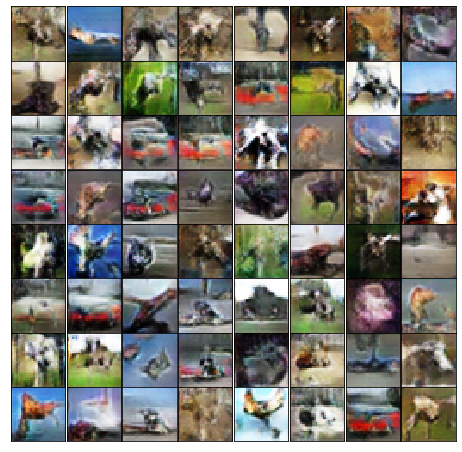

In [ ]:
"""
Run for evaluation purposes (works even if above cells are not executed)
"""

import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

GRID_SIZE = 8
GRID_IMGS = GRID_SIZE ** 2
LATENT_DIM = 100


def plot_final_grid(generated_images):
    """
    Plots the grid of images generated from final model
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./DCGAN/generated_image_grid.png')
    plt.savefig('./results/DCGAN.png')
    plt.show()


def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

# Load best generator model
generator = load_model('./model/DCGAN/best_generator') 

# Pot GRID_IMGS generated images from the model in a GRID_SIZE by GRID_SIZE grid 
gan_images = generator.predict(generate_latent_samples(GRID_IMGS, LATENT_DIM))
plot_final_grid(gan_images)